<a href="https://colab.research.google.com/github/mgo-city/INM707/blob/main/notebooks/INM707_Lab_08_feedback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 08 - DQN with Pytorch

Steps:
- Add wrappers for Dungeon and Ice Dungeon to github repository
- Code a replay buffer
- Code the DQN
- Train
- Compare to RLLib DQN 

This lab will take inspiration from the PyTorch tutorial on DQN, that we will apply to our custom environment Dungeon.

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

We will adapt the concepts step by step to our environment.

In [ ]:
!pip install git+https://github.com/mgo-city/INM707.git

# Loading the dungeon

In [ ]:
from dungeon.dungeon import Dungeon, IceDungeon, index_to_actions
import numpy as np
import random

import matplotlib.pyplot as plt


In [ ]:
SIZE_ENVIR = 20

my_dungeon = Dungeon(SIZE_ENVIR)
my_dungeon.reset()
my_dungeon.display()

X X X X X X X X X X X X X X X X X X X X 
X . . . . . . . . . . X . . . . . . . X 
X . . . . . . . . . A . . . L . . . . X 
X . . . . . . L . . . . . . . . X L . X 
X . . L . . . . . . . . . . . . . . . X 
X . . . . . . . . X . . . . . . . . . X 
X . . X . . . . . . . . . . . . . X . X 
X . . . . L . . . L . . . . . . . . . X 
X . . . . . . . . L . . . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . . L . . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . . . . . L . . . . . X 
X . . . . X . . . . L . . . . . X . . X 
X . . . . . . . . . . . . X . . . . . X 
X . E . . . . . . . . X . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X X X X X X X X X X X X X X X X X X X X 



In [ ]:
my_dungeon.reset()
my_dungeon.display()

X X X X X X X X X X X X X X X X X X X X 
X . . . . . . . . . . X . . . . . . . X 
X . . . . . . . . . . . . . L . . . . X 
X . . . . . . L . . . . . . . . X L . X 
X . . L . . . . . . . . . . . . . . . X 
X . . . . . . . . X . . . . . . . . . X 
X . . X . . . . . . . . . . . . . X . X 
X . . A . L . . . L . . . . . . . . . X 
X . . . . . . . . L . . . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . . L . . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . . . . . L . . . . . X 
X . . . . X . . . . L . . . . . X . . X 
X . . . . . . . . . . . . X . . . . . X 
X . E . . . . . . . . X . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X X X X X X X X X X X X X X X X X X X X 



In [ ]:
obs, _, _ = my_dungeon.step('left')
my_dungeon.display()
for obs_name, o in obs.items():
    print(obs_name)
    print(o)

X X X X X X X X X X X X X X X X X X X X 
X . . . . . . . . . . X . . . . . . . X 
X . . . . . . . . . . . . . L . . . . X 
X . . . . . . L . . . . . . . . X L . X 
X . . L . . . . . . . . . . . . . . . X 
X . . . . . . . . X . . . . . . . . . X 
X . . X . . . . . . . . . . . . . X . X 
X . A . . L . . . L . . . . . . . . . X 
X . . . . . . . . L . . . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . . L . . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . . . . . L . . . . . X 
X . . . . X . . . . L . . . . . X . . X 
X . . . . . . . . . . . . X . . . . . X 
X . E . . . . . . . . X . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X . . . . . . . . . . . . . . . . . . X 
X X X X X X X X X X X X X X X X X X X X 

relative_coordinates
[8 0]
surroundings
[[1 0 0 0 0]
 [1 0 0 1 0]
 [1 0 0 0 0]
 [1 0 0 0 0]
 [1 0 0 0 0]]


# Exercise 1 - Replay Buffer for Experience replay

The first step of this lab is to create a Replay Buffer that will allow us to use Experience Replay and mini-batch learning.
- First, we create a class Transition using named tuple, which holds state transition in a dedicated data structure.
- Then, create a Replay Memory class that collects transition in a First In First Out fashion (fixed memory size). This Replay memory should convert the states, action, rewards into tensors.

The models presented in the Pytorch tutorial are quite generic and can be used as is.

In [ ]:
# Here, add imports from tutorial that you think are necessary


In [ ]:
from collections import namedtuple

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [ ]:
def convert_state(state, normalize, N):

    c = state['relative_coordinates'].flatten()
    o = state['surroundings'].flatten()

    if normalize: 
      c = c / N
      o = o / 4

    state_tensor = np.concatenate( [c,o] )
    state_tensor = torch.tensor(state_tensor, device=device, dtype = torch.float32).unsqueeze(0)
    
    return state_tensor
    

class ReplayMemory:

    # TODO: set up normalization and reward scaling
    # You can also improve it based ion pytorch tutorial (use dequeue)

    def __init__(self, capacity, N, normalize=True, reward_scaling=True):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.normalize = normalize
        self.reward_scaling = reward_scaling
        self.N = N

    def push(self, state, action, next_state, reward):

        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        state_tensor = convert_state(state, self.normalize, self.N)
        
        if next_state is None:
            state_tensor_next = None            
        else:
            state_tensor_next = convert_state(next_state, self.normalize, self.N)
            
        action_tensor = torch.tensor([action], device=device).unsqueeze(0)

        if self.reward_scaling:
            # Scale reward to [0, 1] range
            reward = torch.tensor([reward / self.N**2], device=device).unsqueeze(0)
        else:
            reward = torch.tensor([reward], device=device).unsqueeze(0)

        self.memory[self.position] = Transition(state_tensor, action_tensor, state_tensor_next, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Exercise 2: Q-network

A Q-network is a neural network that maps states to Q-values for each actions.

Implement a first version of Q-networks.
Keep it simple (e.g. 3 hidden layers, with Relu activations).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DQN(nn.Module):

    def __init__(self, input_size, size_hidden, output_size):
        super().__init__()
        
        # Declare the different layers
        self.fc1 = nn.Linear(input_size, size_hidden)
        self.fc2 = nn.Linear(size_hidden, size_hidden)
        self.fc3 = nn.Linear(size_hidden, size_hidden)
        self.fc4 = nn.Linear(size_hidden, output_size)
        
    def forward(self, x):
        # Declare how the data flows from input x to output.
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        output = self.fc4(x)
        return output

# Exercise 3 - Set up the Q-networks

In DQN, the weights of the target network are copied from the weights of policy network every few iterations.

We set the frequency of update using TARGET_UPDATE = 10.

Instead of RMSprop we will use SGD. 

In [ ]:
OBS_SIZE = 5*5 + 2
HIDDEN_SIZE = 256
ACTION_SIZE = 4

Q_network = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target = DQN(OBS_SIZE, HIDDEN_SIZE, ACTION_SIZE).to(device)
Q_target.load_state_dict(Q_network.state_dict())
Q_target.eval()

TARGET_UPDATE = 100
NORMALIZE = True
REWARD_SCALING = False

optimizer = optim.SGD(Q_network.parameters(), lr=0.001)
memory = ReplayMemory(10000, N = SIZE_ENVIR, reward_scaling=False)


# Exercise 4 - Epsilon-greedy policy

You can take inspiration from pytorch tutorial and implement the select_action function.
Or, alternatively, you can implement a E-greedy policy class that will select epsilon greedy actions..


In [ ]:
class E_Greedy_Policy():
    
    def __init__(self, epsilon, decay, min_epsilon):
        
        self.epsilon = epsilon
        self.epsilon_start = epsilon
        self.decay = decay
        self.epsilon_min = min_epsilon
                
    def __call__(self, state):
                
        is_greedy = random.random() > self.epsilon
        
        if is_greedy :
            # we select greedy action
            with torch.no_grad():
                Q_network.eval()
                Q_values = Q_network(state)
                index_action = torch.argmax(Q_values).item()
                Q_network.train()
        else:
            # we sample a random action
            index_action = random.randint(0,3)
        
        return index_action
                
    def update_epsilon(self):
        
        self.epsilon = self.epsilon*self.decay
        if self.epsilon < self.epsilon_min:
            self.epsilon = self.epsilon_min
        
    def reset(self):
        self.epsilon = self.epsilon_start
        
        
policy = E_Greedy_Policy(0.99, decay=0.997, min_epsilon=0.001)

# Exercise 5 - Training loop

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.5

def optimize_model():
    
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q values using policy net
    Q_values = Q_network(state_batch).gather(1, action_batch)
    
    # Compute next Q values using Q_targets
    next_Q_values = torch.zeros(BATCH_SIZE, device=device)
    next_Q_values[non_final_mask] = Q_target(non_final_next_states).max(1)[0].detach()
    
    # Compute targets
    target_Q_values = reward_batch + GAMMA * next_Q_values.unsqueeze(1)
    
    # Compute MSE Loss
    loss = F.mse_loss(Q_values, target_Q_values)
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # Trick: gradient clipping
    #for param in Q_network.parameters():
    #    param.grad.data.clamp_(-1, 1)
        
    optimizer.step()
    
    return loss

In [ ]:
num_episodes = 1000

policy.reset()

rewards_history = []

# Warmup phase!
memory_filled = False

while not memory_filled:
    
    my_dungeon = Dungeon(SIZE_ENVIR)
    state = my_dungeon.reset()
    done = False
        
    while not done:
        
        # Get action and act in the world
        state_tensor = convert_state(state, NORMALIZE, SIZE_ENVIR)
        action = policy(state_tensor)
        action_name = index_to_actions[action].name 
        next_state, reward, done = my_dungeon.step(action_name)
                
        # Observe new state
        if done:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, float(reward))
        
        state = next_state


    memory_filled = memory.capacity == len(memory)

print('Done with the warmup')
    
for i_episode in range(num_episodes):
    
    # New dungeon at every run?
    my_dungeon = Dungeon(SIZE_ENVIR)
    state = my_dungeon.reset()
    done = False
    
    total_reward = 0
    
    while not done:
        
        # Get action and act in the world
        state_tensor = convert_state(state, NORMALIZE, SIZE_ENVIR)
        
        action = policy(state_tensor)
        action_name = index_to_actions[action].name 
        next_state, reward, done = my_dungeon.step(action_name)
        
        total_reward += float(reward)
        
        # Observe new state
        if done:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, float(reward))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization
        started_training = True
        l = optimize_model()

    policy.update_epsilon()
    rewards_history.append( float(total_reward) )

    
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        # We copy the Q-net state into Q-target state
        Q_target.load_state_dict(Q_network.state_dict())
    
    if (i_episode) % 10 == 0:
        
        print('Episode ', i_episode, ': ', 'reward :',  total_reward, 'eps: ', 
              policy.epsilon, ' loss:', l.detach().cpu())   
        print( sum(rewards_history[-10:])/10)    

print('Complete')


Done with the warmup
Episode  0 :  reward : -795.0 eps:  0.98703  loss: tensor(19.1350)
-79.5
Episode  10 :  reward : -233.0 eps:  0.9578156659018894  loss: tensor(10.5060)
-456.6
Episode  20 :  reward : 399.0 eps:  0.9294660241807036  loss: tensor(25.3520)
-394.1
Episode  30 :  reward : 23.0 eps:  0.9019554814785994  loss: tensor(14.4039)
-560.0
Episode  40 :  reward : 346.0 eps:  0.8752592019556485  loss: tensor(7.3027)
-187.9
Episode  50 :  reward : -305.0 eps:  0.8493530848686524  loss: tensor(10.8077)
-339.9
Episode  60 :  reward : 45.0 eps:  0.8242137428135844  loss: tensor(16.1184)
-432.3
Episode  70 :  reward : -755.0 eps:  0.79981848061202  loss: tensor(6.6746)
-430.5
Episode  80 :  reward : 345.0 eps:  0.776145274822487  loss: tensor(0.7547)
-118.3
Episode  90 :  reward : 332.0 eps:  0.7531727538582468  loss: tensor(0.2346)
-563.6
Episode  100 :  reward : -555.0 eps:  0.7308801786935519  loss: tensor(0.2699)
-237.5
Episode  110 :  reward : -925.0 eps:  0.7092474241409645  los

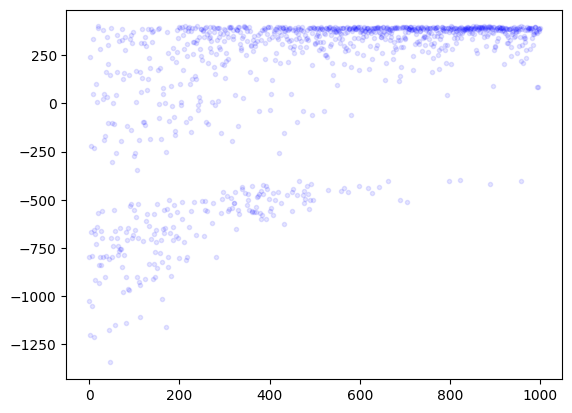

In [ ]:
plt.plot(rewards_history, 'b.', alpha=.1)

# Exercise 5 - Compare results for your DQN, and RLLib DQN